In [39]:
import pickle
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from sklearn.metrics import hamming_loss, accuracy_score
from collections import defaultdict
from scipy.linalg import subspace_angles

### Load consolidated decoding dataframe

In [40]:
decoding_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/degraded_decoding_param_search/degraded_decoding_param_search_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode = pd.DataFrame(dat_decode)

/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [41]:
# Helpful ways to index / look at the df_decode
filtered_df_decode = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == 'AM') & (df_decode['dimreduc_method'] == 'PCA') ]
df_decode.columns

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'predictions', 'loss',
       'decoding_object', 'Xtrain', 'Xtest', 'Ytrain', 'Ytest', 'decoder',
       'decoder_args', 'thresholds', 'data_file', 'loader', 'loader_args',
       'task_args', 'data_path', 'results_file'],
      dtype='object')

In [42]:
data_path = df_decode['data_path']

#### Load the processed data as well for other info

In [43]:
glob.glob(df_decode['data_path'][0] + "/preloaded/*.pickle")

['/home/marcush/Data/TsaoLabData/split/degraded/preloaded/preloadDict.pickle',
 '/home/marcush/Data/TsaoLabData/split/degraded/preloaded/CCA_35_dims.pickle',
 '/home/marcush/Data/TsaoLabData/split/degraded/preloaded/preloaded_data_1.pickle',
 '/home/marcush/Data/TsaoLabData/split/degraded/preloaded/preloaded_data_3.pickle',
 '/home/marcush/Data/TsaoLabData/split/degraded/preloaded/preloaded_data_0.pickle',
 '/home/marcush/Data/TsaoLabData/split/degraded/preloaded/CCA_371_dims.pickle',
 '/home/marcush/Data/TsaoLabData/split/degraded/preloaded/preloaded_data_2.pickle']

In [44]:
preloaded_data_path = glob.glob(df_decode['data_path'][0] + "/preloaded/preloaded_data_*.pickle")[0]
with open(preloaded_data_path, 'rb') as f:
    preload_dat = pickle.load(f) 


In [45]:
preload_dat["StimulusNames"]

['degraded_CR.png',
 'degraded_CR_blur.png',
 'degraded_CR_contrast.png',
 'degraded_CR_mooney_gray.png',
 'degraded_CR_noise.png',
 'degraded_CR_occ-banana.png',
 'degraded_CR_occ-body.png',
 'degraded_CR_occ-bottle.png',
 'degraded_CR_occ-box.png',
 'degraded_CR_occ-rand1.png',
 'degraded_CR_occ-rand2.png',
 'degraded_DC.png',
 'degraded_DC_blur.png',
 'degraded_DC_contrast.png',
 'degraded_DC_mooney_gray.png',
 'degraded_DC_noise.png',
 'degraded_DC_occ-banana.png',
 'degraded_DC_occ-body.png',
 'degraded_DC_occ-bottle.png',
 'degraded_DC_occ-box.png',
 'degraded_DC_occ-rand1.png',
 'degraded_DC_occ-rand2.png',
 'degraded_JH_old.png',
 'degraded_JH_old_blur.png',
 'degraded_JH_old_contrast.png',
 'degraded_JH_old_mooney_gray.png',
 'degraded_JH_old_noise.png',
 'degraded_JH_old_occ-banana.png',
 'degraded_JH_old_occ-body.png',
 'degraded_JH_old_occ-bottle.png',
 'degraded_JH_old_occ-box.png',
 'degraded_JH_old_occ-rand1.png',
 'degraded_JH_old_occ-rand2.png',
 'degraded_ND.png',
 'd

### Extract useful params and get average classification error 

In [46]:
degradedIDs = preload_dat['degradedIDs']
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_decode['dimreduc_method'])
stimIDs = preload_dat['StimIDs']

In [47]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_losses = recursive_defaultdict()
 
for dr_method in dimreduc_methods:
    for reg in regions:
        all_losses[dr_method][reg] = np.zeros(len(dimensions))
        for idx, dim in enumerate(dimensions):

            df_decode_filt = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim)]
            avg_loss = np.mean(df_decode_filt['loss']) # averages loss over k_fold splits
            all_losses[dr_method][reg][idx] = avg_loss

## Average classification accuracy in subspaces

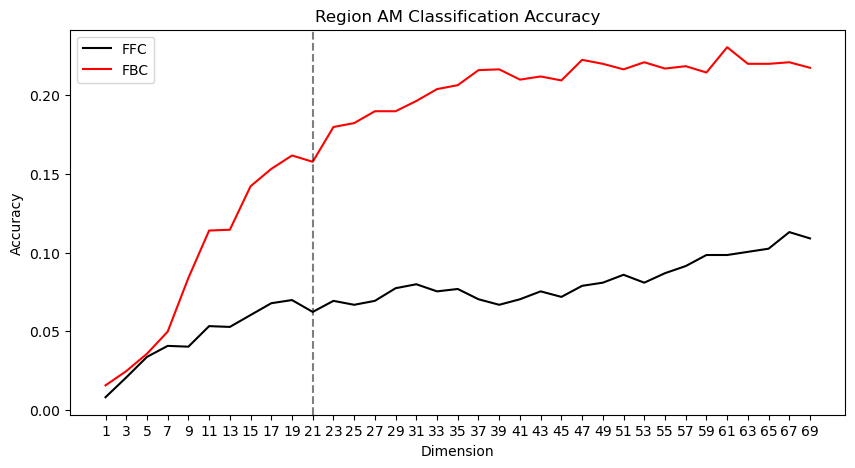

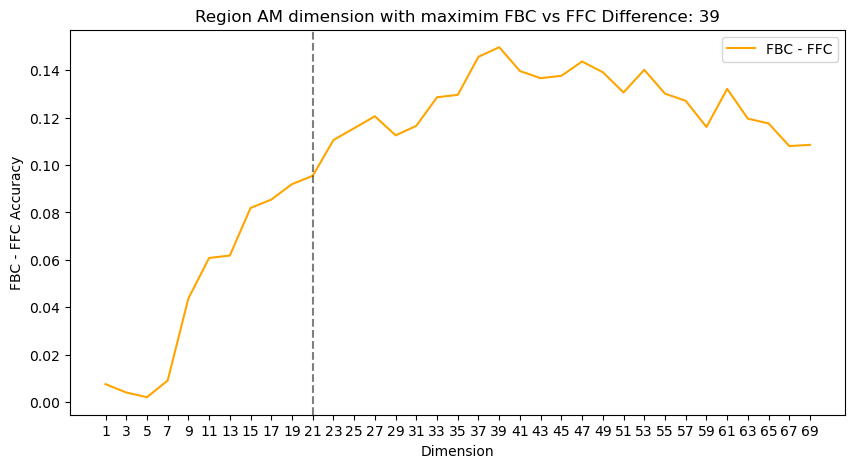

Max fold difference: 3.2407058291229935


In [50]:
region = 'AM'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

"""" 
plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, [np.sum(FFC_losses[0:idx]) for idx, loss in enumerate(FFC_losses) ], label="FFC")
plt.plot(dimensions, [np.sum(FBC_losses[0:idx]) for idx, loss in enumerate(FBC_losses) ], label="FBC")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions[0:-2])
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()

"""

plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximim FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")



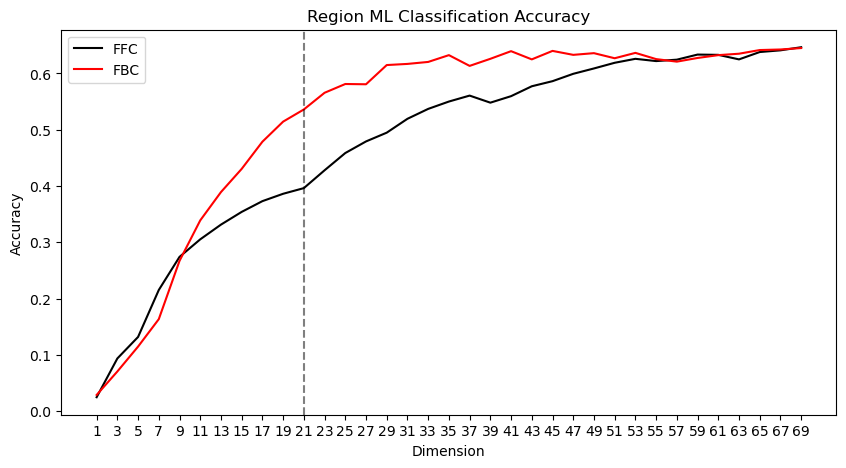

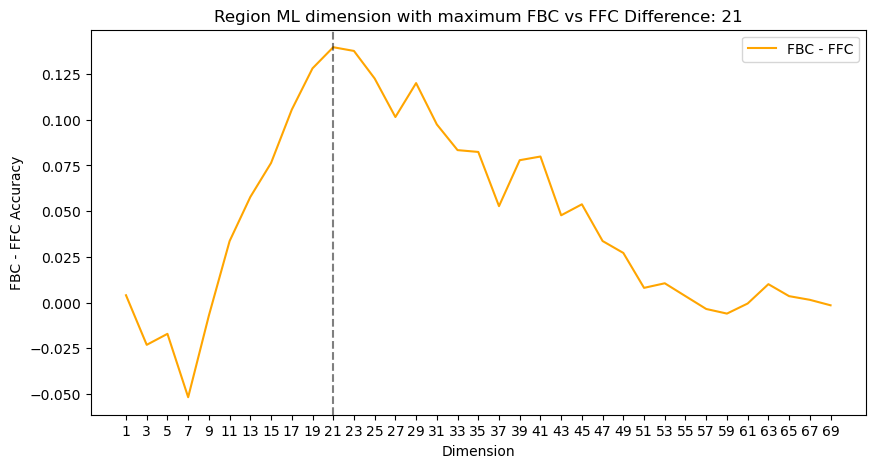

Max fold difference: 1.352342637787269


In [49]:
region = 'ML'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximum FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()


print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")


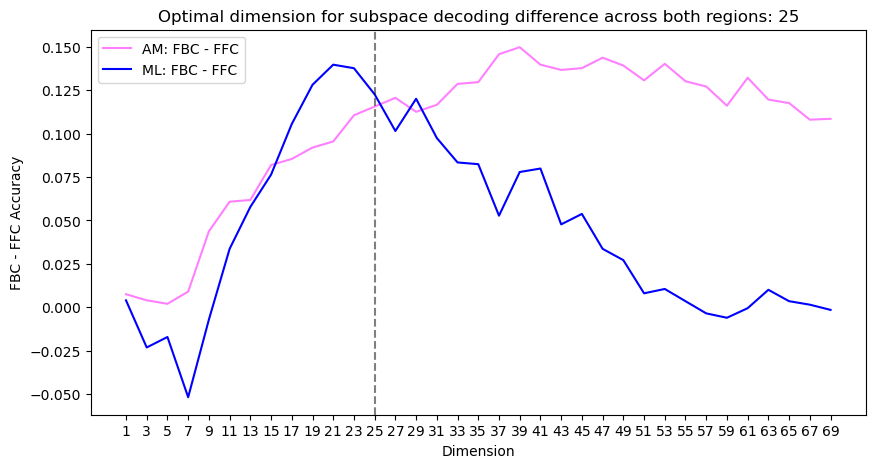

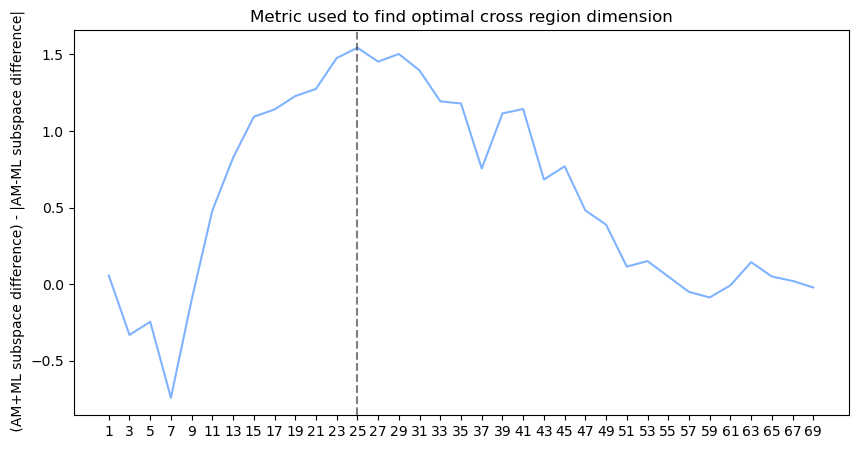

ML max diff percent : 0.8774779487364479, AM max diff percent: 0.7718331426263705


In [12]:
plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall

region = 'AM'
FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
AM_diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(AM_diff_losses)
max_diff_dim = dimensions[max_dim_ind]
plt.plot(dimensions, AM_diff_losses,label=f"{region}: FBC - FFC", color=[1, 0, 1, 0.5])

region = 'ML'
FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
ML_diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(ML_diff_losses)
max_diff_dim = dimensions[max_dim_ind]
plt.plot(dimensions, ML_diff_losses, color='b', label=f"{region}: FBC - FFC")

"""
Computing the optimal dimension across regions:

    1. For both regions, across all dimensions, find the difference in decoding in FBC and FFC subspaces (specifically, FBC-FFC)
    2. Normalize each area's decoding difference by the maximum decoding difference (this way both regions decoding difference is on the same scale)
    3. Sum across both regions to find dimensions with highest (fraction of each region's total) FBC-FFC decoding difference
    4. Subtract by the per-dimension difference between each region's percent of maximal decoding difference
    5. Find dimension which optimizes this.

"""
ML_perc_max = ML_diff_losses / np.max(ML_diff_losses)
AM_perc_max = AM_diff_losses / np.max(AM_diff_losses)

combined_perc_max = ML_perc_max+AM_perc_max
metric = combined_perc_max - np.abs(ML_perc_max-AM_perc_max)
opt_dim_ind = np.argmax(metric)
opt_dim = dimensions[opt_dim_ind]


plt.legend()
plt.title(f'Optimal dimension for subspace decoding difference across both regions: {opt_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color='r', linestyle='--') 
plt.axvline(x=opt_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()



plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, metric, label="ML: FBC - FFC", color=[0.5, 0.7, 1, 1])
plt.axvline(x=opt_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.xticks(dimensions)
plt.title(f'Metric used to find optimal cross region dimension')
plt.ylabel(' (AM+ML subspace difference) - |AM-ML subspace difference|')
plt.show()

print(f"ML max diff percent : {ML_perc_max[opt_dim_ind]}, AM max diff percent: {AM_perc_max[opt_dim_ind]}")

#print(" ")
#for idx, dim in enumerate(dimensions):
#    print(f"Dim: {dim}, ML max diff percent : {np.round(ML_perc_max[idx]*100, 3)}, AM max diff percent: {np.round(AM_perc_max[idx]*100, 3)}")




## Average classification accuracy on degraded vs clear faces

In [13]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_type_accuracies = recursive_defaultdict()

for dr_method in dimreduc_methods:
    for reg in regions:
        for dim_idx, dim in enumerate(dimensions):

            degraded_accuracy = np.zeros(len(n_folds))
            clear_accuracy = np.zeros(len(n_folds))
            for n_fold in n_folds:

                df_decode_filt = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & 
                                        (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim) & (df_decode['fold_idx'] == n_fold)]
                

                pred_labels = df_decode_filt['predictions'].iloc[0]
                true_labels = df_decode_filt['Ytest'].iloc[0]

                # Might consider doing manual accuracy or something instead of loss

                # Accuracy on degraded trials 
                #print(  true_labels.values() )
                deg_trial_inds = np.where(np.isin(true_labels, degradedIDs))[0]
                true_deg_labels = true_labels[deg_trial_inds]
                pred_deg_labels = pred_labels[deg_trial_inds]
                deg_loss = accuracy_score(true_deg_labels, pred_deg_labels)
                degraded_accuracy[n_fold] = deg_loss


                # Accuracy on clear trials 
                clear_trial_inds = np.where(~np.isin(true_labels.astype(int), degradedIDs))[0]
                true_clear_labels = true_labels[clear_trial_inds]
                pred_clear_labels = pred_labels[clear_trial_inds]
                clear_loss = accuracy_score(true_clear_labels, pred_clear_labels)
                clear_accuracy[n_fold] = clear_loss

            all_type_accuracies[reg][dr_method]["deg"][dim_idx] = np.mean(degraded_accuracy)
            all_type_accuracies[reg][dr_method]["clear"][dim_idx] = np.mean(clear_accuracy)



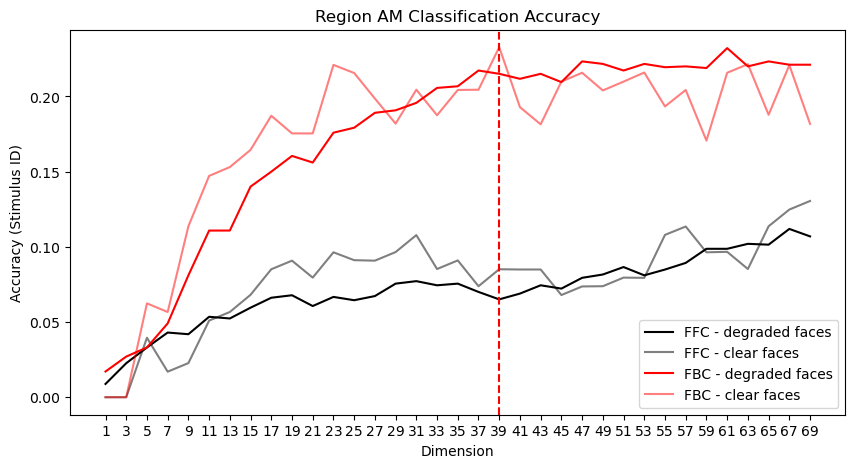

In [14]:
region = 'AM'

FFC_deg_losses = all_type_accuracies[region]['PCA']['deg'].values()
FFC_clear_losses = all_type_accuracies[region]['PCA']['clear'].values()

FBC_deg_losses = all_type_accuracies[region]['LQGCA']['deg'].values()
FBC_clear_losses = all_type_accuracies[region]['LQGCA']['clear'].values()

plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_deg_losses, label="FFC - degraded faces", color=[0,0,0,1])
plt.plot(dimensions, FFC_clear_losses, label="FFC - clear faces", color=[0,0,0,0.5])
plt.plot(dimensions, FBC_deg_losses, label="FBC - degraded faces", color=[1,0,0,1])
plt.plot(dimensions, FBC_clear_losses, label="FBC - clear faces", color=[1,0,0,0.5])
plt.axvline(x=39, color='r', linestyle='--') 

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy (Stimulus ID)')
plt.show()


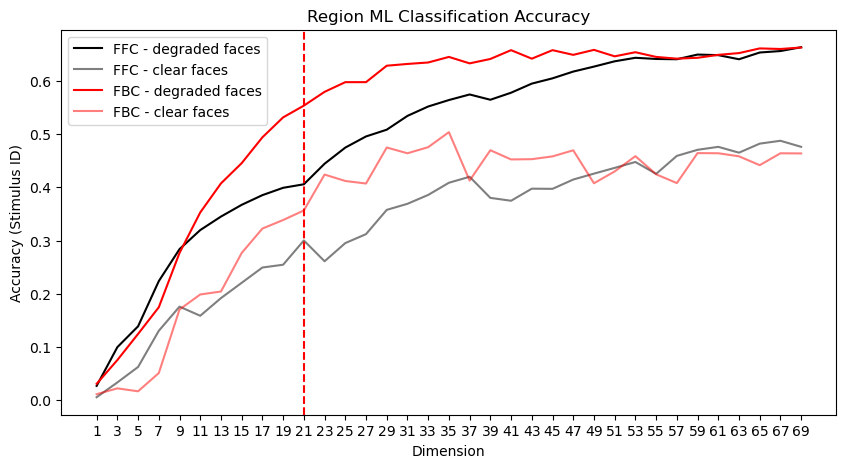

In [15]:
region = 'ML'

FFC_deg_losses = all_type_accuracies[region]['PCA']['deg'].values()
FFC_clear_losses = all_type_accuracies[region]['PCA']['clear'].values()

FBC_deg_losses = all_type_accuracies[region]['LQGCA']['deg'].values()
FBC_clear_losses = all_type_accuracies[region]['LQGCA']['clear'].values()

plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_deg_losses, label="FFC - degraded faces", color=[0,0,0,1])
plt.plot(dimensions, FFC_clear_losses, label="FFC - clear faces", color=[0,0,0,0.5])
plt.plot(dimensions, FBC_deg_losses, label="FBC - degraded faces", color=[1,0,0,1])
plt.plot(dimensions, FBC_clear_losses, label="FBC - clear faces", color=[1,0,0,0.5])
plt.axvline(x=21, color='r', linestyle='--') 

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy (Stimulus ID)')
plt.show()


### Decoding degraded vs clear trials using 1) balanced training data and 2) raw FRs from both regions. 

In [16]:
def make_hashable(d):
    return tuple(sorted((key, make_hashable(value)) if isinstance(value, dict) else (key, value)
                        for key, value in d.items()))


unique_hashes = set(make_hashable(d) for d in df_decode['loader_args'])
unique_dicts = [dict(u) for u in unique_hashes]

for u in unique_dicts:
    u['data_path'] = df_decode['data_path'][0] + "/" + df_decode['data_file'][0]
    u['spike_threshold'] = None
    u['trial_threshold'] = None

In [17]:
preload_dict_path = df_decode['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)


for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)

In [18]:
numTrials = len(AM_loaded_data['stratifiedIDs'])
numdegradedTrials = sum(AM_loaded_data['stratifiedIDs'])
numClearTrials = numTrials - numdegradedTrials

                        
print(f"There are {numTrials} trials: {numdegradedTrials} degraded, {numClearTrials} clear ({np.round((numdegradedTrials/numTrials)*100,3)}% of trials are degraded)")

eg_kf = 5

num_clear_trials = int(numClearTrials * ((eg_kf-1)/eg_kf))
num_degtrials = int(numdegradedTrials / numClearTrials)
print(f"Thus, if one were to do, say {eg_kf} fold CV, it would require seperating the data into {eg_kf*num_degtrials} splits, where there are many repitions of clear faces")

There are 1991 trials: 1814 degraded, 177 clear (91.11% of trials are degraded)
Thus, if one were to do, say 5 fold CV, it would require seperating the data into 50 splits, where there are many repitions of clear faces


In [19]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


stimIDs = AM_loaded_data['StimIDs']

for reg in regions:
        
    if reg == 'AM':
        spike_mat = AM_spikes
    if reg == 'ML':
        spike_mat = ML_spikes

    k_fold = len(n_folds)
    stratIDs = AM_loaded_data['stratifiedIDs']

    clear_trial_inds = np.where(stratIDs == 0)[0]
    deg_trial_inds = np.where(stratIDs == 1)[0]

    num_clear_trials = len(clear_trial_inds)

    # Get n random samples from the clear data trials. Get same number of degraded trials. Train/test a classifier
    train_thresh = 0.75
    num_train_samples = train_thresh*num_clear_trials


    num_clear_splits = 10
    num_deg_splits = 50

    all_loss = np.zeros((num_clear_splits, num_deg_splits))
    alt_loss_deg = np.zeros((num_clear_splits, num_deg_splits))
    alt_loss_clear = np.zeros((num_clear_splits, num_deg_splits))

    # randomly sample 75% of the clear faces for training
    for clf_iter in range(num_clear_splits):
        
        np.random.seed(clf_iter)
        clear_train_inds = np.random.choice(clear_trial_inds, int(num_train_samples), replace=False)
        clear_test_inds = np.array([ trial for trial in clear_trial_inds if trial not in  clear_train_inds ])


        # randomly sample the same number of degraded faces for training
        for split in range(num_deg_splits):
            np.random.seed(split) 

            deg_train_inds = np.random.choice(deg_trial_inds, int(num_train_samples), replace=False)
            deg_test_inds = np.array([ trial for trial in deg_trial_inds if trial not in  deg_train_inds ])


            Xtrain = spike_mat[np.concatenate((clear_train_inds, deg_train_inds)), :]
            Xtest = spike_mat[np.concatenate((clear_test_inds, deg_test_inds)), :]

            # To simply decode degraded vs clear trial
            Ytrain = np.concatenate(( np.zeros(len(clear_train_inds)) ,  np.ones(len(deg_train_inds)) ))
            Ytest = np.concatenate(( np.zeros(len(clear_test_inds)) ,  np.ones(len(deg_test_inds)) ))

            # train a classifier with balanced class labels
            scaler = StandardScaler()
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)


            # Run actual decoder
            clf = LogisticRegression().fit(Xtrain, Ytrain)
            predictions = clf.predict(Xtest)
            loss = hamming_loss(Ytest, predictions)


            #print(len(clear_train_inds), len(deg_train_inds) , len(clear_test_inds), len(deg_test_inds))
            #print( np.sum(predictions)/len(predictions) )

            true_deg_inds = np.where(Ytest == 1)[0]
            alt_loss_deg_indiv = hamming_loss(Ytest[true_deg_inds], predictions[true_deg_inds])
            true_clear_inds = np.where(Ytest == 0)[0]
            alt_loss_clear_indiv = hamming_loss(Ytest[true_clear_inds], predictions[true_clear_inds])
            
            all_loss[clf_iter, split] = loss
            alt_loss_deg[clf_iter, split] = alt_loss_deg_indiv
            alt_loss_clear[clf_iter, split] = alt_loss_clear_indiv

    # For the same split of the clear faces, train/test multiple splits of the degraded faces. average the loss over these
        # then take another split of the clear faces and do the same

    print(f"Region {reg} accuracy on distinguishing clear vs degraded trials (balanced): {np.round((1-np.mean(all_loss))*100,3)}%. Accuracy on degraded trials: {np.round((1-np.mean(alt_loss_deg))*100,3)}%. Accuracy on clear trials: {np.round((1-np.mean(alt_loss_clear))*100,3)}%. ")


Region AM accuracy on distinguishing clear vs degraded trials (balanced): 63.836%. Accuracy on degraded trials: 63.82%. Accuracy on clear trials: 64.436%. 
Region ML accuracy on distinguishing clear vs degraded trials (balanced): 78.702%. Accuracy on degraded trials: 78.58%. Accuracy on clear trials: 83.271%. 


In [20]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


stimIDs = AM_loaded_data['StimIDs']
k_fold = len(n_folds)
stratIDs = AM_loaded_data['stratifiedIDs']

clear_trial_inds = np.where(stratIDs == 0)[0]
deg_trial_inds = np.where(stratIDs == 1)[0]


trial_types = np.array(['clear', 'degraded'])

for reg in regions:

    for trial_type in trial_types:

        if reg == 'AM':
            spike_mat = AM_spikes
        if reg == 'ML':
            spike_mat = ML_spikes


        #all_loss = np.zeros((num_clear_splits, num_deg_splits))
            
        if trial_type == 'clear':
            trial_inds = clear_trial_inds 
        else:
            trial_inds = deg_trial_inds 


        spike_mat_cut = spike_mat[trial_inds, :]
        stimIDs_cut = stimIDs[trial_inds]

        cv = KFold(k_fold)
        splits = cv.split(spike_mat_cut)

        losses = np.zeros(k_fold)

        for i, (train_inds, test_inds) in enumerate(splits):

            Xtrain = spike_mat_cut[train_inds, :]
            Xtest = spike_mat_cut[test_inds, :]

            Ytrain = stimIDs_cut[train_inds]
            Ytest = stimIDs_cut[test_inds]

            scaler = StandardScaler()
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)


            clf = LogisticRegression(multi_class="multinomial").fit(Xtrain, Ytrain)
            predictions = clf.predict(Xtest)
            loss = hamming_loss(Ytest, predictions)
            losses[i] = loss


        print(f"Region {reg} accuracy on {trial_type} trials: {np.round((1-np.mean(losses))*100,3)}%.")

Region AM accuracy on clear trials: 80.127%.
Region AM accuracy on degraded trials: 25.414%.
Region ML accuracy on clear trials: 89.365%.
Region ML accuracy on degraded trials: 63.508%.


In [21]:
clearIDs = [int(ID) for ID in np.unique(stimIDs) if ID not in degradedIDs]

print(f"Number of degraded stimuli: {len(degradedIDs)}, number of clear stimuli: {len(clearIDs)}, number of total stimuli: {len(np.unique(stimIDs))}")
print(f"Chance accuracy for degraded stimuli: {np.round((1/len(degradedIDs))*100,3)}%, chance accuracy for clear stimuli: {np.round((1/len(clearIDs))*100,3)}%, grouped chance accuracy: {np.round((1/len(np.unique(stimIDs)))*100,3)}%")

Number of degraded stimuli: 104, number of clear stimuli: 10, number of total stimuli: 114
Chance accuracy for degraded stimuli: 0.962%, chance accuracy for clear stimuli: 10.0%, grouped chance accuracy: 0.877%


### Getting decoding curves on clear faces only

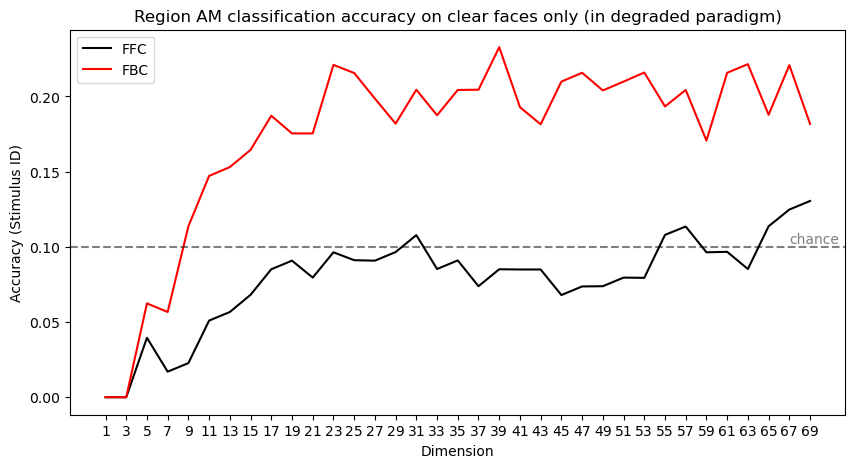

In [52]:
region = 'AM'

FFC_clear_losses = all_type_accuracies[region]['PCA']['clear'].values()
FBC_clear_losses = all_type_accuracies[region]['LQGCA']['clear'].values()

plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_clear_losses, color='black',label="FFC")
plt.plot(dimensions, FBC_clear_losses, color='red',label="FBC")
#plt.axvline(x=35, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/10, color=[0, 0, 0, 0.5], linestyle='--') #, label="chance") 
plt.text(dimensions[-2], 1/10, 'chance', color=[0, 0, 0, 0.5], verticalalignment='bottom')

plt.legend()
plt.title(f'Region {region} classification accuracy on clear faces only (in degraded paradigm)')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy (Stimulus ID)')
plt.show()


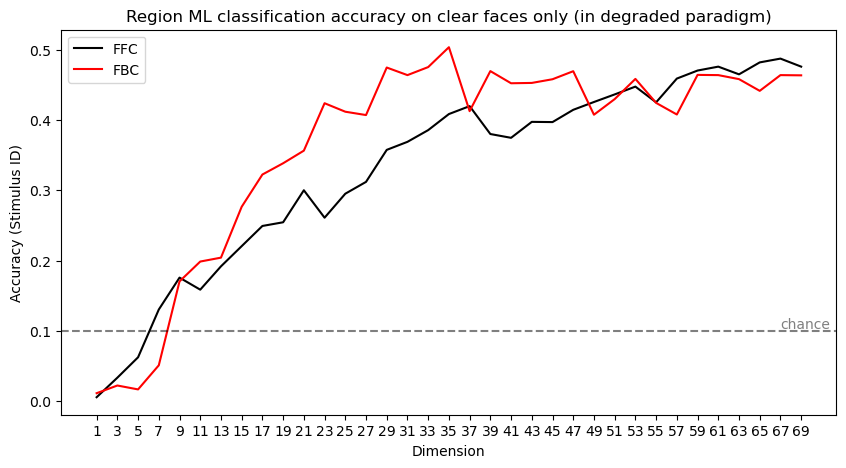

In [53]:
region = 'ML'

FFC_clear_losses = all_type_accuracies[region]['PCA']['clear'].values()
FBC_clear_losses = all_type_accuracies[region]['LQGCA']['clear'].values()

plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_clear_losses, color='black',label="FFC")
plt.plot(dimensions, FBC_clear_losses, color='red',label="FBC")
#plt.axvline(x=35, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/10, color=[0, 0, 0, 0.5], linestyle='--') #, label="chance") 
plt.text(dimensions[-2], 1/10, 'chance', color=[0, 0, 0, 0.5], verticalalignment='bottom')


plt.legend()
plt.title(f'Region {region} classification accuracy on clear faces only (in degraded paradigm)')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy (Stimulus ID)')
plt.show()


### Here I use the same measure of accuracy (Hamming loss) as I did in the FOB stimuli. In the above, I used "accuracy"

In [24]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
clear_face_losses  = recursive_defaultdict()

 
for dr_method in dimreduc_methods:
    for reg in regions:
        all_losses[dr_method][reg] = np.zeros(len(dimensions))
        for idx, dim in enumerate(dimensions):
            dim_losses = np.zeros(len(n_folds))
            for fold in n_folds:

                labels = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim) & (df_decode['fold_idx'] == fold)]["Ytest"].values[0]
                predictions = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim) & (df_decode['fold_idx'] == fold)]["predictions"].values[0]

                clear_trial_inds = [stimid not in degradedIDs for stimid in labels] 

                # Only compute loss on trials with clear faces in them
                loss = hamming_loss(labels[clear_trial_inds], predictions[clear_trial_inds])
                dim_losses[fold] = loss


            clear_face_losses[dr_method][reg][idx] = np.mean(dim_losses)


In [25]:
sum(clear_trial_inds)

36

In [26]:
clear_trial_inds = [stimid not in degradedIDs for stimid in np.array(stimIDs).astype(int)] 

print(f"Number of clear face trials: {sum(clear_trial_inds)}")

Number of clear face trials: 177


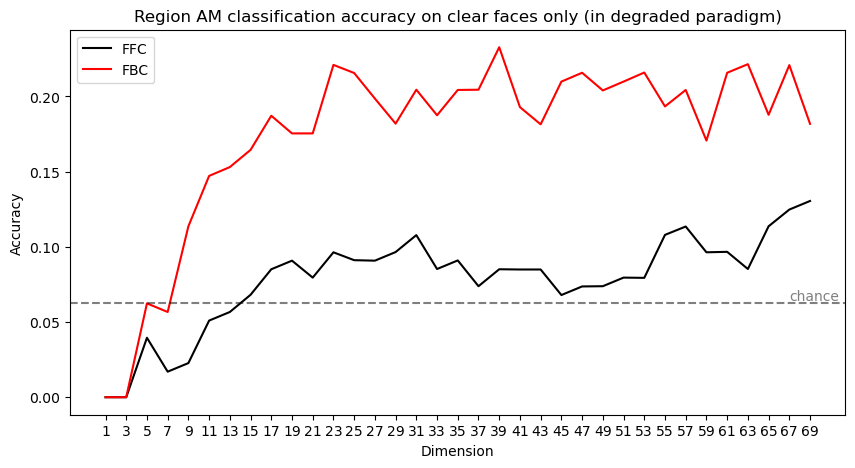

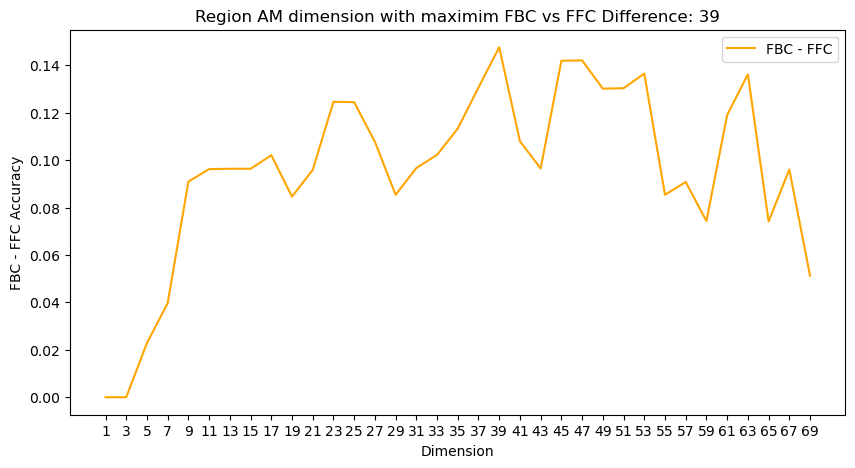

Max fold difference: 2.7350746268656705


In [36]:
region = 'AM'

FFC_losses = 1 - np.array(list(clear_face_losses['PCA'][region].values()))
FBC_losses = 1 - np.array(list(clear_face_losses['LQGCA'][region].values()))
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} classification accuracy on clear faces only (in degraded paradigm)')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/10, color=[0, 0, 0, 0.5], linestyle='--') #, label="chance") 
plt.text(dimensions[-2], 1/10, 'chance', color=[0, 0, 0, 0.5], verticalalignment='bottom')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')
plt.legend()
plt.title(f'Region {region} dimension with maximim FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")



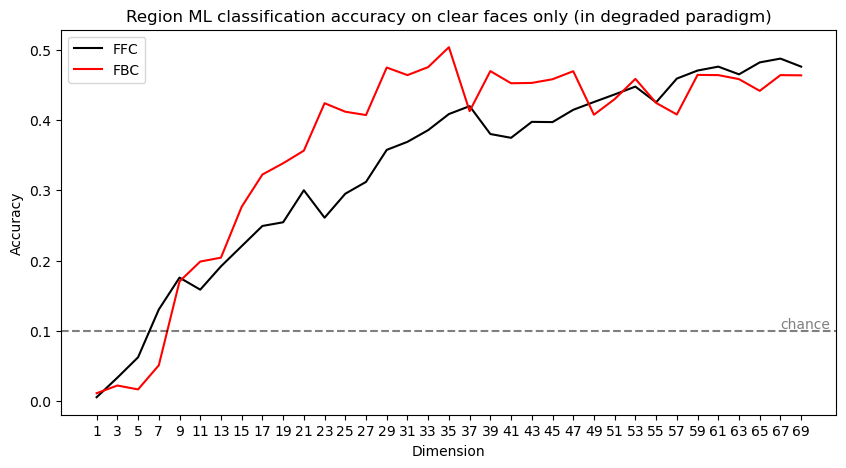

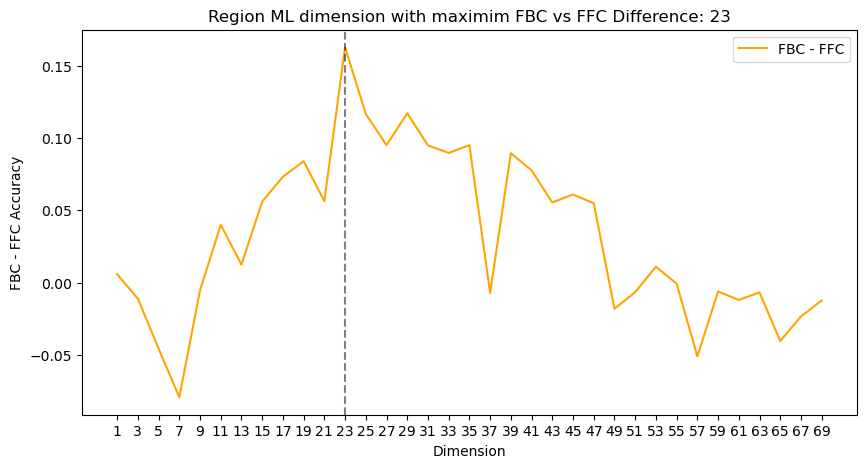

Max fold difference: 1.6237082066869304


In [54]:
region = 'ML'

FFC_losses = 1 - np.array(list(clear_face_losses['PCA'][region].values()))
FBC_losses = 1 - np.array(list(clear_face_losses['LQGCA'][region].values()))
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} classification accuracy on clear faces only (in degraded paradigm)')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/10, color=[0, 0, 0, 0.5], linestyle='--') 
plt.text(dimensions[-2], 1/10, 'chance', color=[0, 0, 0, 0.5], verticalalignment='bottom')
plt.show()


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')
plt.legend()
plt.title(f'Region {region} dimension with maximim FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")

